In [2]:
import numpy as np
import matplotlib.pyplot as plt
import saqqara
from simulator import LISA_AET
import glob
import torch
import swyft
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SequentialSampler
from pytorch_lightning import loggers as pl_loggers
from swyft.networks import OnlineStandardizingLayer
from swyft.networks import ResidualNetWithChannel
import os

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import saqqara
from simulator import LISA_AET
import glob
import torch
import swyft
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SequentialSampler
from pytorch_lightning import loggers as pl_loggers

DATA_DIR = "./new_bounded_simulations/"
Z_FILES = glob.glob(DATA_DIR + "/z_*.npy")
Z_FILES = sorted(Z_FILES, key=lambda x: str(x.split("_")[-1].split(".")[0]))
DATA_FILES = glob.glob(DATA_DIR + "/cg_data_*.npy")
DATA_FILES = sorted(DATA_FILES, key=lambda x: str(x.split("_")[-1].split(".")[0]))

In [4]:
# Check all names match
for idx in range(len(Z_FILES)):
    assert (
        Z_FILES[idx].split("_")[-1].split(".")[0]
        == DATA_FILES[idx].split("_")[-1].split(".")[0]
    )

In [5]:
# Compute total number of simulations
n_simulations = len(Z_FILES) * 128
print(f"Total number of simulations: {n_simulations}")

# Get data shapes
z_shape = np.load(Z_FILES[0]).shape[1:]
data_shape = np.load(DATA_FILES[0]).shape[1:]
print(f"z shape: {z_shape}")
print(f"data shape: {data_shape}")

config = saqqara.load_settings("bounded_config.yaml")
sim = LISA_AET(config)

Total number of simulations: 290048
z shape: (4,)
data shape: (945, 3)
Detector setup complete
Noise matrices computed
Response computed
Coarse graining setup complete


In [6]:
z_dataset = saqqara.NPYDataset(file_paths=Z_FILES)
data_dataset = saqqara.NPYDataset(file_paths=DATA_FILES)
training_dataset = saqqara.TrainingDataset(z_store=z_dataset, data_store=data_dataset)

In [7]:
# Dataset properties
print("Training dataset properties:")
print("length:", len(training_dataset))
print("z shape:", training_dataset["z"][0].shape)
print("data shape:", training_dataset["data"][0].shape)

Training dataset properties:
length: 290048
z shape: torch.Size([4])
data shape: torch.Size([945, 3])


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/saqqara/data.py:45: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return torch.from_numpy(data).float()


In [8]:
def setup_dataloaders(
    dataset,
    total_size=None,
    train_fraction=0.8,
    val_fraction=0.2,
    num_workers=0,
    batch_size=64,
):
    if total_size is None:
        total_size = len(dataset)
    indices = list(range(len(dataset)))
    train_idx, val_idx = int(np.floor(train_fraction * total_size)), int(
        np.floor((train_fraction + val_fraction) * total_size)
    )
    train_indices, val_indices = indices[:train_idx], indices[train_idx:val_idx]
    # train_sampler, val_sampler = SubsetRandomSampler(train_indices), SubsetRandomSampler(val_indices)
    train_sampler, val_sampler = SequentialSampler(train_indices), SequentialSampler(
        val_indices
    )
    train_dataloader = DataLoader(
        dataset=dataset,
        drop_last=True,
        sampler=train_sampler,
        num_workers=int(num_workers),
        batch_size=int(batch_size),
    )
    val_dataloader = DataLoader(
        dataset=dataset,
        drop_last=True,
        sampler=val_sampler,
        num_workers=int(num_workers),
        batch_size=int(batch_size),
    )
    return train_dataloader, val_dataloader

In [9]:
# Check the dataset loading
z_batch = z_dataset[:100]
data_batch = data_dataset[:100]
print("z_batch shape:", z_batch.shape)
print("data_batch shape:", data_batch.shape)

z_batch shape: torch.Size([100, 4])
data_batch shape: torch.Size([100, 945, 3])


In [10]:
z_dataset = saqqara.NPYDataset(file_paths=Z_FILES)
data_dataset = saqqara.NPYDataset(file_paths=DATA_FILES)
training_dataset = saqqara.TrainingDataset(z_store=z_dataset, data_store=data_dataset)

In [11]:
total_size = 290_000
learning_rate = 1e-5
batch_size = 2048
train_dl, val_dl = setup_dataloaders(training_dataset, total_size=total_size, num_workers=10, batch_size=batch_size)

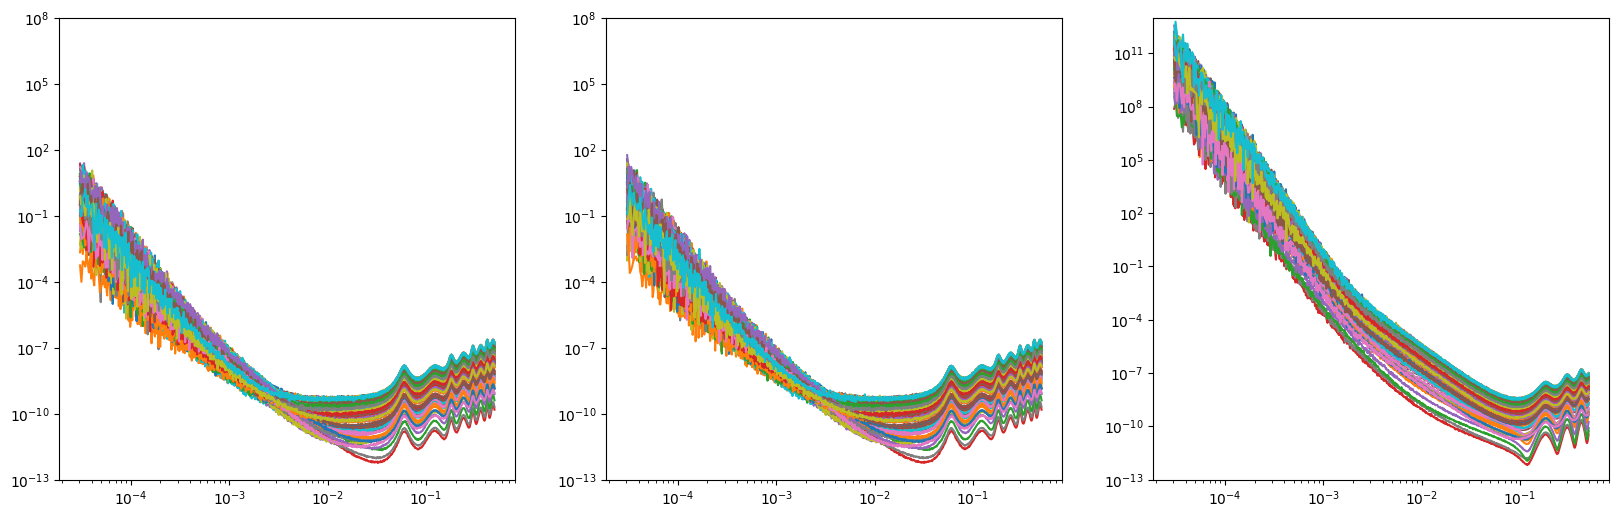

In [11]:
fig = plt.figure(figsize=(20, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.loglog(sim.coarse_grained_f, data_batch[:, :, i].T)
    if i < 2:
        plt.ylim(1e-13, 1e8)
    else:
        plt.ylim(1e-13, 1e13)

In [12]:
class InferenceNetwork(swyft.SwyftModule, swyft.AdamWReduceLROnPlateau):
    def __init__(self, sim=None):
        super().__init__()
        self.sim = sim
        self.learning_rate = learning_rate
        self.early_stopping_patience = 100
        self.num_feat_param = 3  # Number of channels
        self.num_params = 2
        self.npts = sim.coarse_grained_f.shape[0]
        #self.npts = 650
        self.nl_AA = OnlineStandardizingLayer(shape=(self.npts,))
        self.nl_EE = OnlineStandardizingLayer(shape=(self.npts,))
        self.nl_TT = OnlineStandardizingLayer(shape=(self.npts,))
        self.nl_AA_nolog = OnlineStandardizingLayer(shape=(self.npts,))
        self.nl_EE_nolog = OnlineStandardizingLayer(shape=(self.npts,))
        self.nl_TT_nolog = OnlineStandardizingLayer(shape=(self.npts,))
        self.resnet = ResidualNetWithChannel(
            channels=3,
            in_features=self.npts,
            out_features=self.num_params,
            hidden_features=64,
            num_blocks=2,
            dropout_probability=0.1,
            use_batch_norm=True,
        )
        self.resnet_no_log = ResidualNetWithChannel(
            channels=3,
            in_features=self.npts,
            out_features=self.num_params,
            hidden_features=64,
            num_blocks=2,
            dropout_probability=0.1,
            use_batch_norm=True,
        )
        self.fc_AA = torch.nn.Linear(self.npts, sim.nparams)
        self.fc_EE = torch.nn.Linear(self.npts, sim.nparams)
        self.fc_TT = torch.nn.Linear(self.npts, sim.nparams)
        self.marginals = self.get_marginals(self.num_params)
        self.lrs1d = swyft.LogRatioEstimator_1dim(
            #num_features=self.num_feat_param,
            num_features=2 * self.num_feat_param * self.num_params,
            num_params=self.num_params,
            varnames="z",
            num_blocks=3,
            hidden_features=64,
            dropout=0.1,
        )
        self.lrs2d = swyft.LogRatioEstimator_Ndim(
            #num_features=2 * self.num_feat_param,
            num_features=2 * self.num_feat_param * self.num_params,
            marginals=self.marginals,
            num_blocks=3,
            hidden_features=64,
            varnames="z",
            dropout=0.1,
        )

    def forward(self, A, B):
        log_data = torch.log(A["data"])
        # reshape to (batch, num_channels, num_freqs)
        log_data = log_data.transpose(1, 2)
        norm_AA = self.nl_AA(log_data[..., 0, :])
        norm_EE = self.nl_EE(log_data[..., 1, :])
        norm_TT = self.nl_TT(log_data[..., 2, :])

        full_data = torch.stack([norm_AA, norm_EE, norm_TT], dim=-2)
        no_log_data = torch.exp(full_data)
        norm_AA_nolog = self.nl_AA_nolog(no_log_data[..., 0, :])
        norm_EE_nolog = self.nl_EE_nolog(no_log_data[..., 1, :])
        norm_TT_nolog = self.nl_TT_nolog(no_log_data[..., 2, :])
        no_log_data = torch.stack([norm_AA_nolog, norm_EE_nolog, norm_TT_nolog], dim=-2)

        compression = self.resnet(full_data)
        no_log_compression = self.resnet_no_log(no_log_data)
        s1 = compression.reshape(-1, self.num_params * self.num_feat_param)
        s2 = no_log_compression.reshape(-1, self.num_params * self.num_feat_param)
        s = torch.cat((s1, s2), dim=1)
        # lrs1d = self.lrs1d(s, B["z"][:, :2])
        lrs2d = self.lrs2d(s, B["z"][:, :2])
        #return lrs1d, lrs2d
        return lrs2d

    @staticmethod
    def get_marginals(n_params):
        marginals = []
        for i in range(n_params):
            for j in range(n_params):
                if j > i:
                    marginals.append((i, j))
        return tuple(marginals)


In [13]:
logger = pl_loggers.WandbLogger(
    offline=False,
    name=f"bounded_{total_size}_{learning_rate}_{batch_size}",
    project="saqqara",
    entity="j-b-g-alvey",
    log_model="all",
    config=config,
)
device = "gpu" if torch.cuda.is_available() else "cpu"
trainer = swyft.SwyftTrainer(accelerator=device, max_epochs=100, logger=logger)
network = InferenceNetwork(sim=sim)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: j-b-g-alvey. Use `wandb login --relogin` to force relogin


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [20]:
trainer.fit(network, train_dl, val_dl) #, ckpt_path="./saqqara/qttnqehl/checkpoints/epoch=99-step=12500.ckpt")

/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type                     | Param

Sanity Checking: 0it [00:00, ?it/s]

/home/alveyjbg/mambaforge/envs/default/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 0:  80%|████████  | 113/141 [00:08<00:02, 13.16it/s, loss=-0.0221, v_num=j5x5] 

/home/alveyjbg/mambaforge/envs/default/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 99: 100%|██████████| 141/141 [00:11<00:00, 12.18it/s, loss=-1.3, v_num=j5x5, val_loss=-1.30]    

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 141/141 [00:11<00:00, 12.18it/s, loss=-1.3, v_num=j5x5, val_loss=-1.30]
Reloading best model: ./saqqara/30thj5x5/checkpoints/epoch=96-step=10961.ckpt


In [14]:
# amort_ckpt = "./saqqara/nzaw9p9m/checkpoints/epoch=94-step=18525.ckpt" # resnet model, 2 params only, no log data included (17/5)
amort_ckpt = "./saqqara/ae6mjehp/checkpoints/epoch=96-step=37830.ckpt" # resnet model, 2 params only, no log data included (29/5)
# bound_ckpt_1 = "./saqqara/obnuttga/checkpoints/epoch=93-step=14664.ckpt" # resnet model, 2 params only, no log data included, bounded, lr 1e-5 (20/5)
# bound_ckpt_2 = "./saqqara/jgtxwq4c/checkpoints/epoch=88-step=6942.ckpt" # resnet model, 2 params only, no log data included, bounded, lr 5e-5 (20/5)
# bound_ckpt = "./saqqara/haxmk749/checkpoints/epoch=91-step=8556.ckpt" # resnet model, 2 params only, better bounding, no log data included, lr 5e-5 (22/5)
# bound_ckpt = "./saqqara/qttnqehl/checkpoints/epoch=99-step=12500.ckpt"  # resnet model, 2 params only, better bounding, no log data included, lr 1e-5 (22/5)
bound_ckpt = "./saqqara/30thj5x5/checkpoints/epoch=96-step=10961.ckpt" # resnet model, 2 params, from better bounded model, lr 1e-5 (29/5)

In [13]:
ckpt_2d = "./saqqara/4t50vl93/checkpoints/epoch=87-step=27456.ckpt" # 2d only, 2 params, lr 1e-5 (23/5)

In [15]:
def load_network_state(network, checkpoint):
    state_dict = torch.load(checkpoint)['state_dict']
    network.load_state_dict(state_dict)
    return network

In [16]:
amort_nn = load_network_state(InferenceNetwork(sim=sim), amort_ckpt)
bound_nn = load_network_state(InferenceNetwork(sim=sim), bound_ckpt)
# bound_nn_1 = load_network_state(InferenceNetwork(sim=sim), bound_ckpt_1)
# bound_nn_2 = load_network_state(InferenceNetwork(sim=sim), bound_ckpt_2)

In [17]:
def get_grid(N, a_low, a_high, g_low, g_high, A_low=0., A_high=6., P_low=0., P_high=30.):
    a_samples = np.linspace(a_low, a_high, N)
    g_samples = np.linspace(g_low, g_high, N)
    ag_samples = np.array(np.meshgrid(a_samples, g_samples)).T.reshape(-1, 2)
    A_samples = np.ones(N)
    P_samples = np.ones(N)
    AP_samples = np.array(np.meshgrid(A_samples, P_samples)).T.reshape(-1, 2)
    return swyft.Samples(z=np.float32(np.concatenate((ag_samples, AP_samples), axis=1)))

In [18]:
def get_samples(N, a_low, a_high, g_low, g_high, A_low=0., A_high=6., P_low=0., P_high=30.):
    a_sample = np.random.uniform(a_low, a_high, N)
    g_sample = np.random.uniform(g_low, g_high, N)
    A_sample = np.random.uniform(A_low, A_high, N)
    P_sample = np.random.uniform(P_low, P_high, N)
    z_sample = np.float32(np.vstack((a_sample, g_sample, A_sample, P_sample)).T)
    return swyft.Samples(z=z_sample)

In [19]:
observation = sim.sample(conditions={"z": np.array([-11, 0.0, np.random.normal(3., 0.6), np.random.normal(15., 3.)])})
observation["data"] = torch.tensor(observation["coarse_grained_data"])
dict_keys = list(observation.keys())
for k in dict_keys:
    if k not in ["z", "data"]:
        observation.pop(k)

/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)


In [47]:
prior_samples = get_grid(1000, -11.2, -10.8, -0.5, 0.5)

In [22]:
prior_samples

Samples({'z': array([[-11.2       ,  -0.5       ,   1.        ,   1.        ],
       [-11.2       ,  -0.48989898,   1.        ,   1.        ],
       [-11.2       ,  -0.479798  ,   1.        ,   1.        ],
       ...,
       [-10.8       ,   0.479798  ,   1.        ,   1.        ],
       [-10.8       ,   0.48989898,   1.        ,   1.        ],
       [-10.8       ,   0.5       ,   1.        ,   1.        ]],
      dtype=float32)})

In [21]:
observation = sim.sample(conditions={"z": np.array([-11, 0.0, np.random.normal(3., 0.6), np.random.normal(15., 3.)])})
observation["data"] = torch.tensor(observation["coarse_grained_data"])
dict_keys = list(observation.keys())
for k in dict_keys:
    if k not in ["z", "data"]:
        observation.pop(k)

In [29]:
prior_samples = get_samples(100_000, -11.2, -10.8, -0.5, 0.5)

In [48]:
amort_logratios = trainer.infer(amort_nn, observation, prior_samples, batch_size=32000)
bound_logratios = trainer.infer(bound_nn, observation, prior_samples, batch_size=32000)

# bound_logratios_1 = trainer.infer(bound_nn_1, observation, prior_samples, batch_size=1024)
# bound_logratios_2 = trainer.infer(bound_nn_2, observation, prior_samples, batch_size=1024)

/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 32/32 [00:04<00:00,  7.47it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 32/32 [00:03<00:00,  8.08it/s]


In [22]:
bound_logratios

LogRatioSamples(logratios=tensor([[-7.5910],
        [-7.5884],
        [-7.5856],
        ...,
        [-7.6509],
        [-7.6438],
        [-7.6368]]), params=tensor([[[-11.2000,  -0.5000]],

        [[-11.2000,  -0.4899]],

        [[-11.2000,  -0.4798]],

        ...,

        [[-10.8000,   0.4798]],

        [[-10.8000,   0.4899]],

        [[-10.8000,   0.5000]]]), parnames=array([['z[0]', 'z[1]']], dtype='<U4'), metadata={})

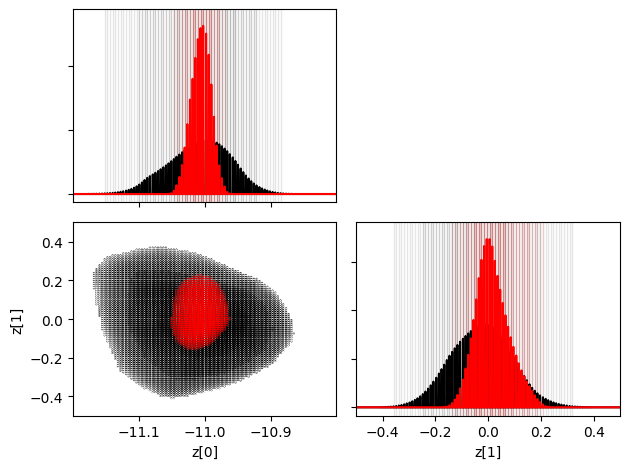

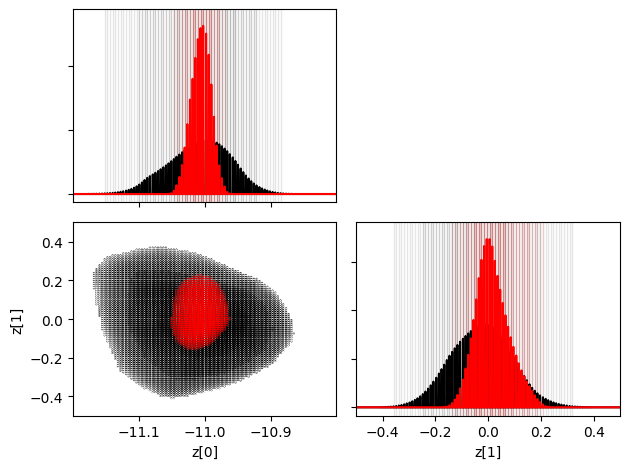

In [47]:
swyft.plot_corner(amort_logratios, parnames=amort_logratios.parnames[0], bins=1000, color='black')
swyft.plot_corner(bound_logratios, parnames=amort_logratios.parnames[0], bins=1000, color='red', fig=plt.gcf())

In [49]:
params = bound_logratios.params[:, 0, :]
logratios = bound_logratios.logratios[:, 0]

In [38]:
params

tensor([[-11.2000,  -0.5000],
        [-11.2000,  -0.4980],
        [-11.2000,  -0.4960],
        ...,
        [-10.8000,   0.4960],
        [-10.8000,   0.4980],
        [-10.8000,   0.5000]])

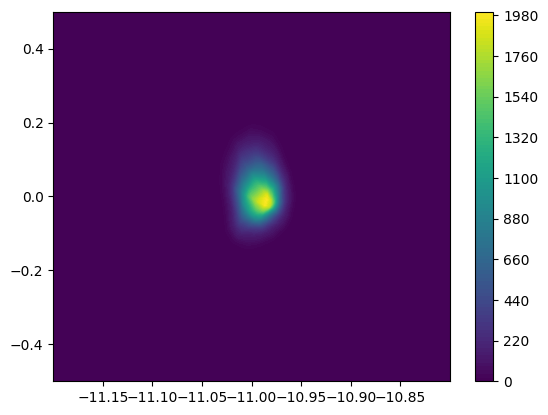

In [45]:
plt.contourf(params[:, 0].reshape(500, 500), params[:, 1].reshape(500, 500), np.exp(logratios.reshape(500, 500)), levels=100)
plt.colorbar()

  0%|          | 0/1000 [00:00<?, ?it/s]/tmp/ipykernel_3743197/66969125.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('cool')
100%|██████████| 1000/1000 [00:01<00:00, 969.21it/s]


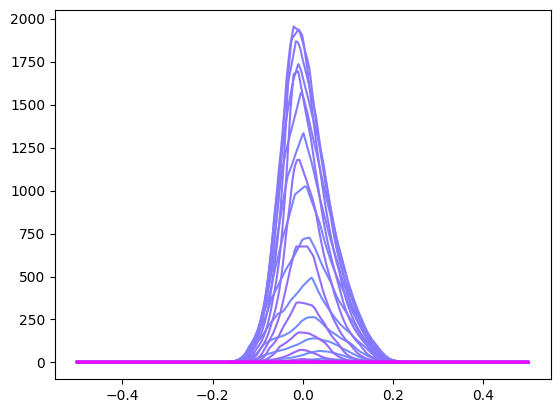

In [50]:
N = 1000
import tqdm
for i in tqdm.tqdm(range(N)):
    if i % 10 == 0:
        ps = params[N * i: N * (i + 1), 1]
        ap = params[N * i, 0]
        # color by value of ap

        # # Create a colormap based on the values of `ap`
        cmap = plt.cm.get_cmap('cool')
        line = plt.plot(ps, np.exp(logratios[N * i: N * (i + 1)]), color=cmap(i / N), alpha=1)

(-0.5, 0.5)

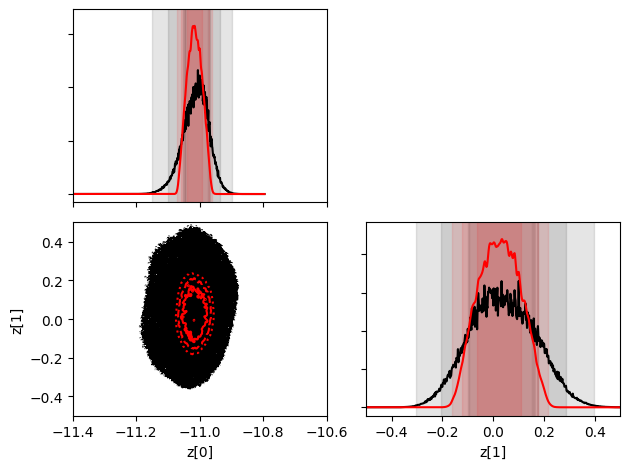

In [33]:
swyft.plot_corner(amort_logratios, parnames=["z[0]", "z[1]"], bins=1000);
swyft.plot_corner(bound_logratios, parnames=["z[0]", "z[1]"], fig=plt.gcf(), bins=1000, color='r', smooth=2.0)
#swyft.plot_corner(bound_logratios_2, parnames=["z[0]", "z[1]"], fig=plt.gcf(), bins=100, color='g')
ax = plt.subplot(2, 2, 1)
plt.xlim(-11.4, -10.6)
ax = plt.subplot(2, 2, 4)
plt.xlim(-0.5, 0.5)
ax = plt.subplot(2, 2, 3)
plt.xlim(-11.4, -10.6)
plt.ylim(-0.5, 0.5)

(-1.0, 1.0)

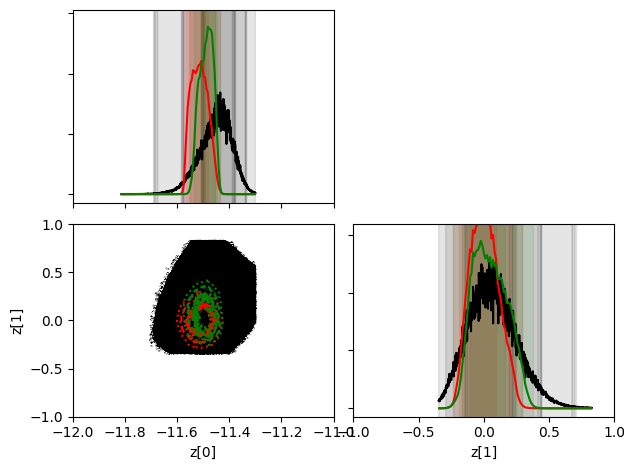

In [29]:
swyft.plot_corner(amort_logratios, parnames=["z[0]", "z[1]"], bins=1000);
swyft.plot_corner(bound_logratios_1, parnames=["z[0]", "z[1]"], fig=plt.gcf(), bins=100, color='r')
swyft.plot_corner(bound_logratios_2, parnames=["z[0]", "z[1]"], fig=plt.gcf(), bins=100, color='g')
ax = plt.subplot(2, 2, 1)
plt.xlim(-12., -11)
ax = plt.subplot(2, 2, 4)
plt.xlim(-1, 1)
ax = plt.subplot(2, 2, 3)
plt.xlim(-12., -11)
plt.ylim(-1, 1)

In [39]:
swyft.get_rect_bounds(bound_logratios_1, threshold=1e-6)

[RectangleBounds(bounds=tensor([[[-11.6115, -11.3668]],
 
         [[ -0.3470,   0.3475]]]), parnames=array([['z[0]'],
        ['z[1]']], dtype='<U4')),
 RectangleBounds(bounds=tensor([[[-11.5623, -11.2997],
          [ -0.3470,   0.6214]]]), parnames=array([['z[0]', 'z[1]']], dtype='<U4'))]

In [30]:
coverage_train_dl, coverage_val_dl = setup_dataloaders(training_dataset, total_size=100000, num_workers=10, batch_size=2000)
for batch in train_dl:
    z_arr = batch["z"]
    data_arr = batch["data"]
dm = swyft.Samples(z=z_arr, data=data_arr)

/home/alveyjbg/mambaforge/envs/default/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [40]:
amort_coverage_samples = trainer.test_coverage(amort_nn, dm, prior_samples)

/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 161.03it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 50176/50176 [07:44<00:00, 107.98it/s]


In [45]:
COV_DATA_DIR = "./new_bounded_simulations/"
COV_Z_FILES = glob.glob(COV_DATA_DIR + "/z_*.npy")
COV_Z_FILES = sorted(COV_Z_FILES, key=lambda x: str(x.split("_")[-1].split(".")[0]))
COV_DATA_FILES = glob.glob(COV_DATA_DIR + "/cg_data_*.npy")
COV_DATA_FILES = sorted(COV_DATA_FILES, key=lambda x: str(x.split("_")[-1].split(".")[0]))
cov_z_dataset = saqqara.NPYDataset(file_paths=COV_Z_FILES)
cov_data_dataset = saqqara.NPYDataset(file_paths=COV_DATA_FILES)
cov_training_dataset = saqqara.TrainingDataset(z_store=cov_z_dataset, data_store=cov_data_dataset)
coverage_train_dl, _ = setup_dataloaders(cov_training_dataset, total_size=10000, num_workers=10, batch_size=2000, train_fraction=1.0)
for batch in coverage_train_dl:
    z_arr = batch["z"]
    data_arr = batch["data"]
dm = swyft.Samples(z=z_arr, data=data_arr)

/home/alveyjbg/mambaforge/envs/default/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [46]:
coverage_prior_samples = sim.sample(100_000, targets=['z'])

100%|██████████| 100000/100000 [00:01<00:00, 81582.36it/s]


In [47]:
coverage_samples = trainer.test_coverage(bound_nn, dm, coverage_prior_samples, batch_size=64000)

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 63/63 [00:00<00:00, 206.17it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4000/4000 [14:42<00:00,  4.53it/s]


In [48]:
coverage_samples

CoverageSamples(prob_masses=tensor([[0.7889],
        [0.0457],
        [0.1314],
        ...,
        [0.3438],
        [0.8744],
        [0.1033]]), params=tensor([[[-11.4123,   0.6912]],

        [[-11.0283,  -0.3866]],

        [[-10.8872,   0.5947]],

        ...,

        [[-11.0620,   0.1473]],

        [[-10.9454,  -0.0570]],

        [[-10.7534,   0.4744]]]), parnames=array([['z[0]', 'z[1]']], dtype='<U4'))

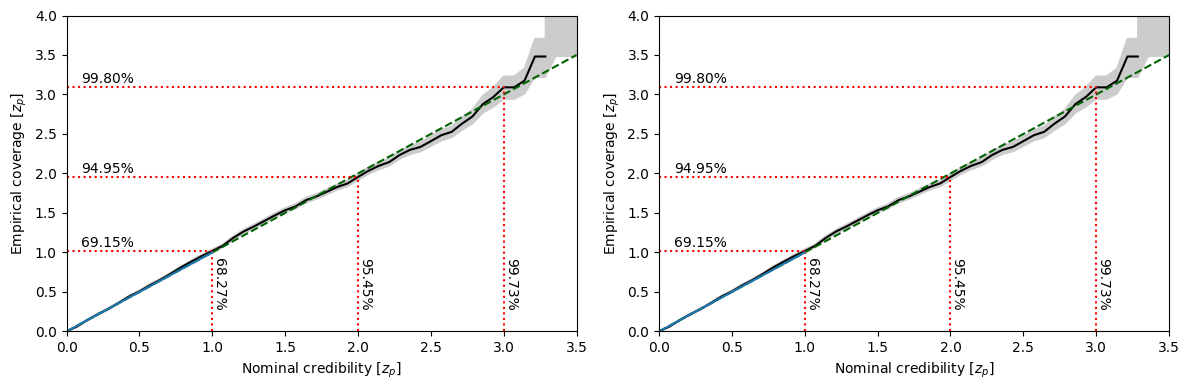

In [51]:
fix, axes = plt.subplots(1, 2, figsize = (12, 4))
for i in range(2):
    ax = axes[i]
    ax.plot([0, 0], [1, 1], c='r')
    swyft.plot_zz(coverage_samples, ['z[0]', 'z[1]'], ax = axes[i])
    axes[i].plot([0.0, 1.0], [0.0, 1.0])
plt.tight_layout()

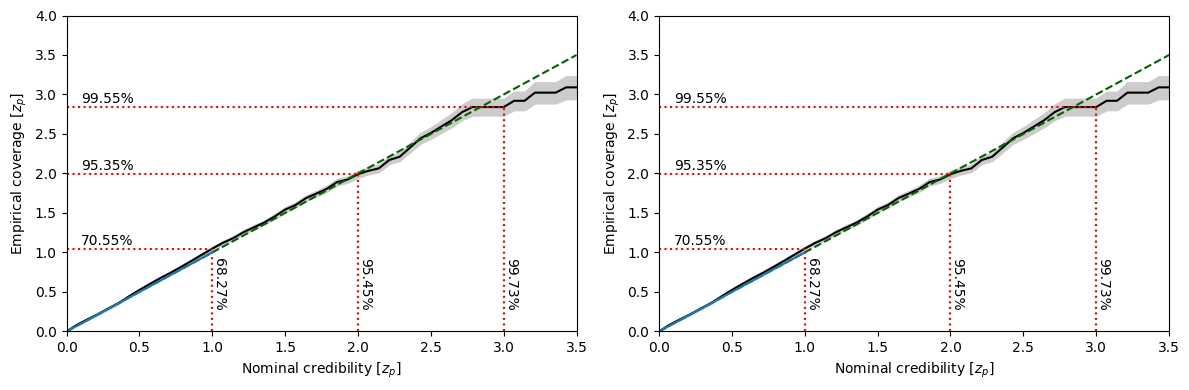

In [44]:
fix, axes = plt.subplots(1, 2, figsize = (12, 4))
for i in range(2):
    ax = axes[i]
    ax.plot([0, 0], [1, 1], c='r')
    swyft.plot_zz(coverage_samples, ['z[0]', 'z[1]'], ax = axes[i])
    axes[i].plot([0.0, 1.0], [0.0, 1.0])
plt.tight_layout()

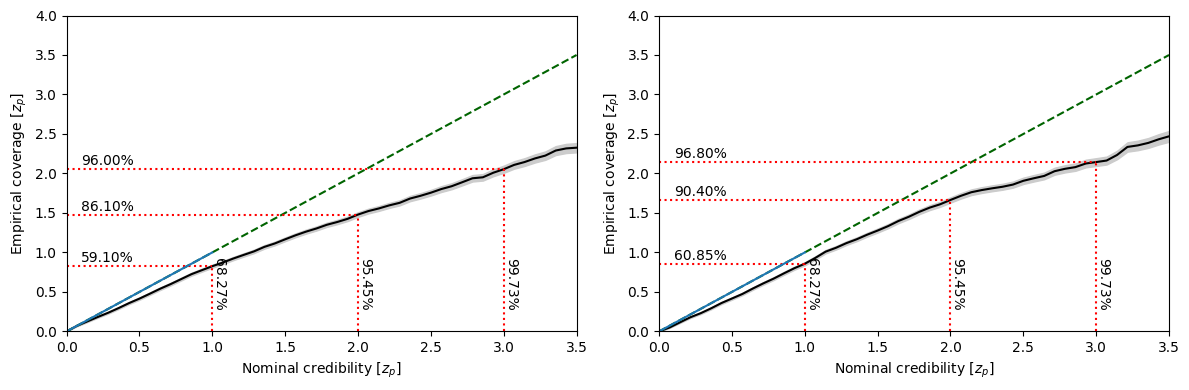

In [65]:
fix, axes = plt.subplots(1, 2, figsize = (12, 4))
for i in range(2):
    ax = axes[i]
    ax.plot([0, 0], [1, 1], c='r')
    swyft.plot_zz(new_coverage_samples, "z[%i]"%i, ax = axes[i])
    axes[i].plot([0.0, 1.0], [0.0, 1.0])
plt.tight_layout()

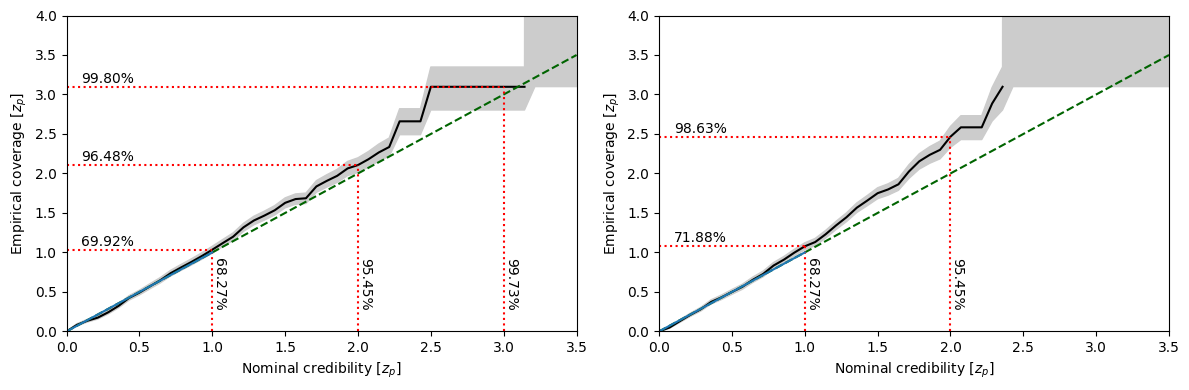

In [43]:
fix, axes = plt.subplots(1, 2, figsize = (12, 4))
for i in range(2):
    ax = axes[i]
    ax.plot([0, 0], [1, 1], c='r')
    swyft.plot_pp(bound_coverage_samples, "z[%i]"%i, ax = axes[i])
    axes[i].plot([0.0, 1.0], [0.0, 1.0])
plt.tight_layout()

Test the point wise coverage on the test example.

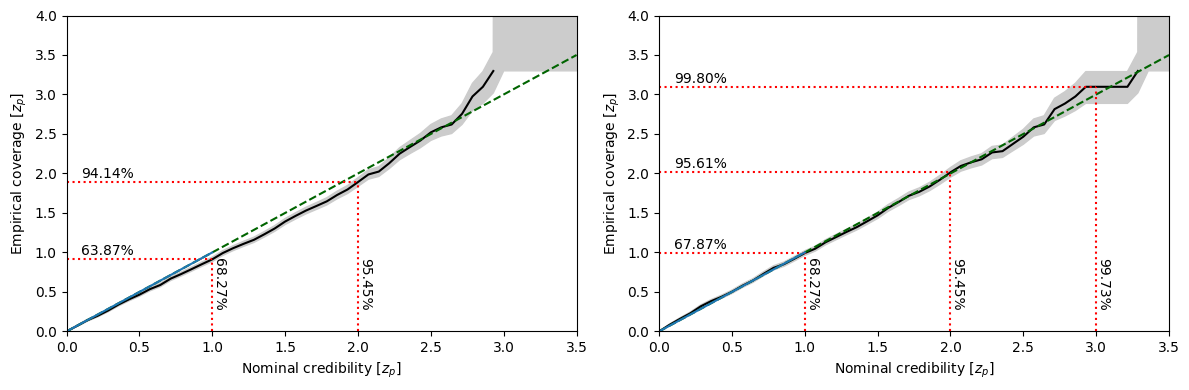

In [33]:
fix, axes = plt.subplots(1, 2, figsize = (12, 4))
for i in range(2):
    ax = axes[i]
    ax.plot([0, 0], [1, 1], c='r')
    swyft.plot_zz(bound_coverage_samples, "z[%i]"%i, ax = axes[i])
    axes[i].plot([0.0, 1.0], [0.0, 1.0])
plt.tight_layout()

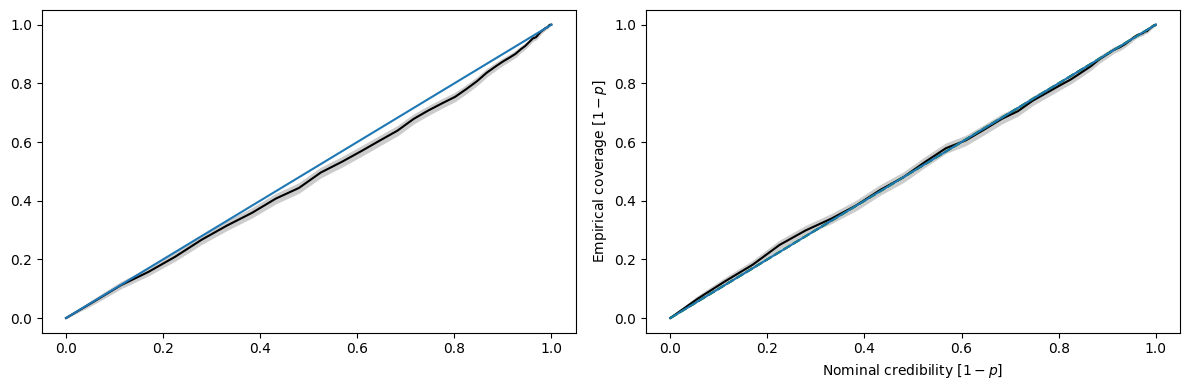

In [34]:
fix, axes = plt.subplots(1, 2, figsize = (12, 4))
for i in range(2):
    ax = axes[i]
    ax.plot([0, 0], [1, 1], c='r')
    swyft.plot_pp(bound_coverage_samples, "z[%i]"%i, ax = axes[i])
    axes[i].plot([0.0, 1.0], [0.0, 1.0])
plt.tight_layout()

In [1]:
fix, axes = plt.subplots(1, 2, figsize = (12, 4))
for i in range(2):
    ax = axes[i]
    ax.plot([0, 0], [1, 1], c='r')
    swyft.plot_pp(amort_coverage_samples, "z[%i]"%i, ax = axes[i])
    axes[i].plot([0.0, 1.0], [0.0, 1.0])
plt.tight_layout()

NameError: name 'plt' is not defined

100%|██████████| 100000/100000 [00:01<00:00, 66555.86it/s]
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which w

Predicting DataLoader 0: 100%|██████████| 98/98 [00:01<00:00, 78.79it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:01<00:00, 86.22it/s]


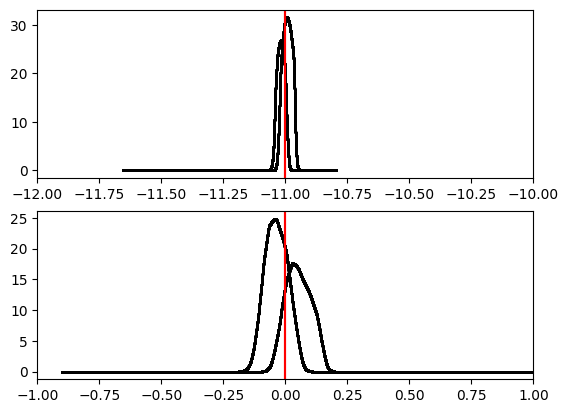

In [35]:
interp_arr = np.linspace(-11.25, -10.8, 10000)
prod = np.ones_like(interp_arr)
prior_samples = sim.sample(100_000, targets=['z'])
from scipy.interpolate import interp1d
for _ in range(2):
    observation = sim.sample(conditions={"z": np.array([-11., 0.0, np.random.normal(3., 0.6), np.random.normal(15., 3.)])})
    observation["data"] = torch.tensor(observation["coarse_grained_data"])
    dict_keys = list(observation.keys())
    for k in dict_keys:
        if k not in ["z", "data"]:
            observation.pop(k) 
    logratios = trainer.infer(bound_nn, observation, prior_samples, batch_size=1024)   
    ax = plt.subplot(2, 1, 1)
    idxs = np.argsort(logratios[0].params[:, 0, 0])
    p_func = interp1d(logratios[0].params[idxs, 0, 0], torch.exp(logratios[0].logratios[idxs, 0]))
    prod *= p_func(interp_arr)
    plt.scatter(logratios[0].params[::2, 0, 0], torch.exp(logratios[0].logratios[::2, 0]), s=0.5, c='k')
    plt.xlim(-12, -10)
    plt.axvline(-11., c="r")
    ax = plt.subplot(2, 1, 2)
    plt.scatter(logratios[0].params[::2, 1, 0], torch.exp(logratios[0].logratios[::2, 1]), s=0.5, c='k')
    plt.xlim(-1, 1)
    plt.axvline(0.0, c="r")

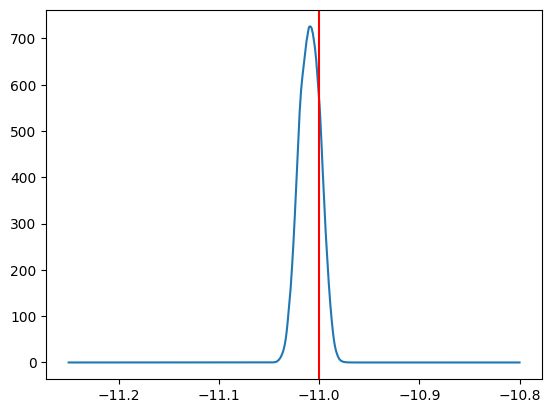

In [36]:
plt.plot(interp_arr, prod)
plt.axvline(-11.0, c='r')

In [48]:
bounds = swyft.get_rect_bounds(logratios, threshold=1e-5)

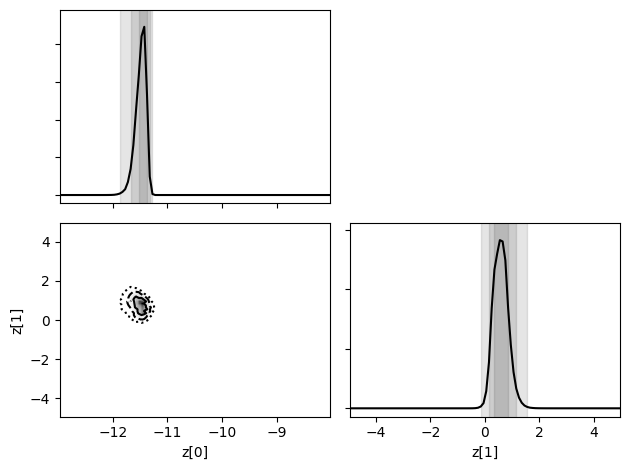

In [53]:
swyft.plot_corner(logratios, parnames=["z[0]", "z[1]"]);

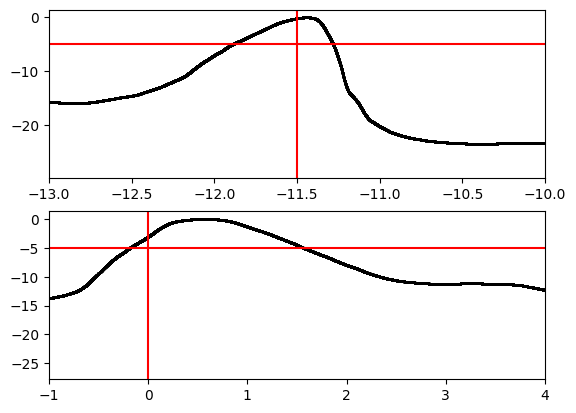

In [47]:
ax = plt.subplot(2, 1, 1)
plt.scatter(logratios[0].params[::2, 0, 0], logratios[0].logratios[::2, 0] - torch.max(logratios[0].logratios[::2, 0]), s=0.5, c='k')
plt.xlim(-13, -10)
plt.axvline(-11.5, c="r")
plt.axhline(-5., c='r')
ax = plt.subplot(2, 1, 2)
plt.scatter(logratios[0].params[::2, 1, 0], logratios[0].logratios[::2, 1] - torch.max(logratios[0].logratios[::2, 1]), s=0.5, c='k')
plt.xlim(-1, 4)
plt.axhline(-5., c='r')
plt.axvline(0.0, c="r")

In [17]:
bounds_list = []
for ctr in range(100):
    print("Run:", ctr)
    observation = sim.sample(conditions={"z": np.array([-11.5, 0.0, 3., 15.])})
    observation["data"] = torch.tensor(observation["coarse_grained_data"])
    dict_keys = list(observation.keys())
    for k in dict_keys:
        if k not in ["z", "data"]:
            observation.pop(k)
    logratios = trainer.infer(network, observation, prior_samples, batch_size=1024)   
    bounds_list.append(swyft.get_rect_bounds(logratios, threshold=1e-5))
    # ax = plt.subplot(2, 1, 1)
    # plt.scatter(logratios[0].params[::2, 0, 0], torch.exp(logratios[0].logratios[::2, 0]), s=0.5, c='k')
    # plt.xlim(-12, -11)
    # plt.axvline(-11.5, c="r")
    # ax = plt.subplot(2, 1, 2)
    # plt.scatter(logratios[0].params[::2, 1, 0], torch.exp(logratios[0].logratios[::2, 1]), s=0.5, c='k')
    # plt.xlim(-1, 1)
    # plt.axvline(0.0, c="r")

Run: 0


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 105.00it/s]
Run: 1


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:01<00:00, 88.03it/s]
Run: 2


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 102.52it/s]
Run: 3


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 111.78it/s]
Run: 4


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 102.11it/s]
Run: 5


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 99.67it/s] 
Run: 6


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 103.54it/s]
Run: 7


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:01<00:00, 96.39it/s] 
Run: 8


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 107.56it/s]
Run: 9


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 123.29it/s]
Run: 10


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 116.81it/s]
Run: 11


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 108.91it/s]
Run: 12


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 125.90it/s]
Run: 13


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:01<00:00, 93.38it/s]
Run: 14


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 99.55it/s] 
Run: 15


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 98.12it/s]
Run: 16


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 107.76it/s]
Run: 17


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 124.08it/s]
Run: 18


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 119.14it/s]
Run: 19


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 112.84it/s]
Run: 20


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 114.44it/s]
Run: 21


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 121.40it/s]
Run: 22


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:01<00:00, 88.91it/s] 
Run: 23


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 125.52it/s]
Run: 24


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 112.67it/s]
Run: 25


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 121.97it/s]
Run: 26


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 112.72it/s]
Run: 27


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 135.10it/s]
Run: 28


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 107.59it/s]
Run: 29


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 125.78it/s]
Run: 30


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 126.76it/s]
Run: 31


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 108.31it/s]
Run: 32


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:01<00:00, 97.89it/s] 
Run: 33


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 100.87it/s]
Run: 34


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 110.74it/s]
Run: 35


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 99.64it/s] 
Run: 36


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 112.89it/s]
Run: 37


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 113.87it/s]
Run: 38


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 115.42it/s]
Run: 39


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 120.66it/s]
Run: 40


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:01<00:00, 96.71it/s] 
Run: 41


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 121.63it/s]
Run: 42


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 122.89it/s]
Run: 43


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 99.27it/s] 
Run: 44


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 109.20it/s]
Run: 45


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 113.45it/s]
Run: 46


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 133.46it/s]
Run: 47


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 105.64it/s]
Run: 48


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 107.93it/s]
Run: 49


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:01<00:00, 95.24it/s] 
Run: 50


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 102.96it/s]
Run: 51


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 102.48it/s]
Run: 52


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 111.47it/s]
Run: 53


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 106.12it/s]
Run: 54


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:01<00:00, 96.46it/s] 
Run: 55


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 103.17it/s]
Run: 56


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 104.91it/s]
Run: 57


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 106.12it/s]
Run: 58


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 110.37it/s]
Run: 59


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 116.91it/s]
Run: 60


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 117.24it/s]
Run: 61


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:01<00:00, 94.46it/s]
Run: 62


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 107.62it/s]
Run: 63


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 100.53it/s]
Run: 64


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:01<00:00, 88.80it/s] 
Run: 65


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 109.37it/s]
Run: 66


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 116.99it/s]
Run: 67


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 110.14it/s]
Run: 68


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 105.21it/s]
Run: 69


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 109.40it/s]
Run: 70


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 99.88it/s] 
Run: 71


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 100.84it/s]
Run: 72


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 98.01it/s] 
Run: 73


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 101.70it/s]
Run: 74


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 103.51it/s]
Run: 75


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 106.54it/s]
Run: 76


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 111.74it/s]
Run: 77


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 100.01it/s]
Run: 78


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 101.44it/s]
Run: 79


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:01<00:00, 94.92it/s]
Run: 80


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 113.89it/s]
Run: 81


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 108.30it/s]
Run: 82


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:01<00:00, 97.68it/s]
Run: 83


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 120.66it/s]
Run: 84


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 110.87it/s]
Run: 85


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:01<00:00, 86.88it/s] 
Run: 86


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:01<00:00, 94.93it/s] 
Run: 87


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 111.36it/s]
Run: 88


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 126.42it/s]
Run: 89


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 102.05it/s]
Run: 90


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 103.25it/s]
Run: 91


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 113.38it/s]
Run: 92


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 103.67it/s]
Run: 93


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 108.11it/s]
Run: 94


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 106.64it/s]
Run: 95


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 100.62it/s]
Run: 96


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 120.22it/s]
Run: 97


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 107.12it/s]
Run: 98


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 112.40it/s]
Run: 99


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 108.52it/s]


In [18]:
min_a, max_a, min_g, max_g = -13., -9., -5., 5.

In [19]:
for idx in range(len(bounds_list)):
    min_a = float(max(min_a, bounds_list[idx][0].bounds[0, 0, 0], bounds_list[idx][1].bounds[0, 0, 0]))
    max_a = float(min(max_a, bounds_list[idx][0].bounds[0, 0, 1], bounds_list[idx][1].bounds[0, 0, 1]))
    min_g = float(max(min_g, bounds_list[idx][0].bounds[1, 0, 0], bounds_list[idx][1].bounds[0, 1, 0]))
    max_g = float(min(max_g, bounds_list[idx][0].bounds[1, 0, 1], bounds_list[idx][1].bounds[0, 1, 1]))

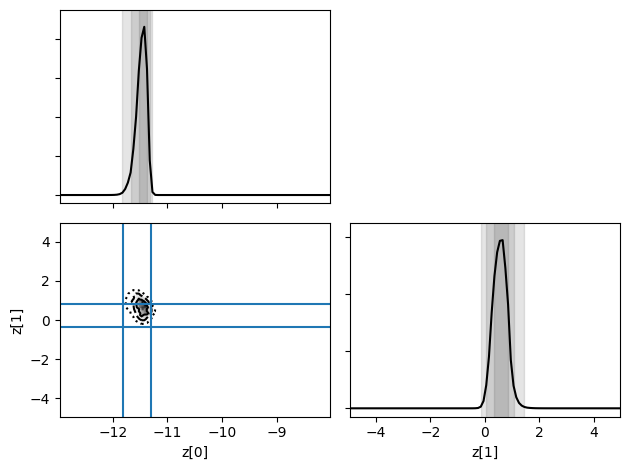

In [20]:
swyft.plot_corner(logratios, parnames=["z[0]", "z[1]"])
ax = plt.subplot(2, 2, 3)
plt.axhline(min_g)
plt.axhline(max_g)
plt.axvline(min_a)
plt.axvline(max_a)

In [21]:
min_a, max_a, min_g, max_g

(-11.814586639404297,
 -11.299675941467285,
 -0.3469740152359009,
 0.8286179900169373)


Analysing observation #1


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.45it/s]

Analysing observation #2


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.46it/s]

Analysing observation #3


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.45it/s]

Analysing observation #4


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.38it/s]

Analysing observation #5


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.41it/s]

Analysing observation #6


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.36it/s]

Analysing observation #7


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.42it/s]

Analysing observation #8


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.44it/s]

Analysing observation #9


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.44it/s]

Analysing observation #10


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.67it/s]

Analysing observation #11


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.46it/s]

Analysing observation #12


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.26it/s]

Analysing observation #13


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.32it/s]

Analysing observation #14


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.19it/s]

Analysing observation #15


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.27it/s]

Analysing observation #16


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.72it/s]

Analysing observation #17


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.42it/s]

Analysing observation #18


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.41it/s]

Analysing observation #19


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.42it/s]

Analysing observation #20


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.40it/s]

Analysing observation #21


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.45it/s]

Analysing observation #22


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.39it/s]

Analysing observation #23


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.44it/s]

Analysing observation #24


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.46it/s]

Analysing observation #25


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.42it/s]

Analysing observation #26


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.39it/s]

Analysing observation #27


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.40it/s]

Analysing observation #28


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.44it/s]

Analysing observation #29


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.41it/s]

Analysing observation #30


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.41it/s]

Analysing observation #31


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.42it/s]

Analysing observation #32


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.48it/s]

Analysing observation #33


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.74it/s]

Analysing observation #34


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.44it/s]

Analysing observation #35


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.46it/s]

Analysing observation #36


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.40it/s]

Analysing observation #37


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.33it/s]

Analysing observation #38


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.32it/s]

Analysing observation #39


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.35it/s]

Analysing observation #40


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.42it/s]

Analysing observation #41


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.40it/s]

Analysing observation #42


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.77it/s]

Analysing observation #43


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.47it/s]

Analysing observation #44


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.40it/s]

Analysing observation #45


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.41it/s]

Analysing observation #46


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.43it/s]

Analysing observation #47


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.38it/s]

Analysing observation #48


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.34it/s]

Analysing observation #49


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.36it/s]

Analysing observation #50


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.35it/s]

Analysing observation #51


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.68it/s]

Analysing observation #52


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.69it/s]

Analysing observation #53


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.70it/s]

Analysing observation #54


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.40it/s]

Analysing observation #55


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.40it/s]

Analysing observation #56


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.40it/s]

Analysing observation #57


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.47it/s]

Analysing observation #58


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.33it/s]

Analysing observation #59


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.60it/s]

Analysing observation #60


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.39it/s]

Analysing observation #61


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.42it/s]

Analysing observation #62


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.38it/s]

Analysing observation #63


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.33it/s]

Analysing observation #64


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.41it/s]

Analysing observation #65


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.43it/s]

Analysing observation #66


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.40it/s]

Analysing observation #67


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.31it/s]

Analysing observation #68


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.63it/s]

Analysing observation #69


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.61it/s]

Analysing observation #70


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.70it/s]

Analysing observation #71


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.34it/s]

Analysing observation #72


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.31it/s]

Analysing observation #73


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.37it/s]

Analysing observation #74


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.31it/s]

Analysing observation #75


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.28it/s]

Analysing observation #76


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.34it/s]

Analysing observation #77


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.24it/s]

Analysing observation #78


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.36it/s]

Analysing observation #79


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.40it/s]

Analysing observation #80


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.34it/s]

Analysing observation #81


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.30it/s]

Analysing observation #82


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.34it/s]

Analysing observation #83


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.30it/s]

Analysing observation #84


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.26it/s]

Analysing observation #85


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.39it/s]

Analysing observation #86


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.40it/s]

Analysing observation #87


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.41it/s]

Analysing observation #88


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.37it/s]

Analysing observation #89


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.35it/s]

Analysing observation #90


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.27it/s]

Analysing observation #91


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.35it/s]

Analysing observation #92


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.34it/s]

Analysing observation #93


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.36it/s]

Analysing observation #94


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.33it/s]

Analysing observation #95


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.34it/s]

Analysing observation #96


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.37it/s]

Analysing observation #97


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.33it/s]

Analysing observation #98


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.66it/s]

Analysing observation #99


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.51it/s]

Analysing observation #100


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.57it/s]


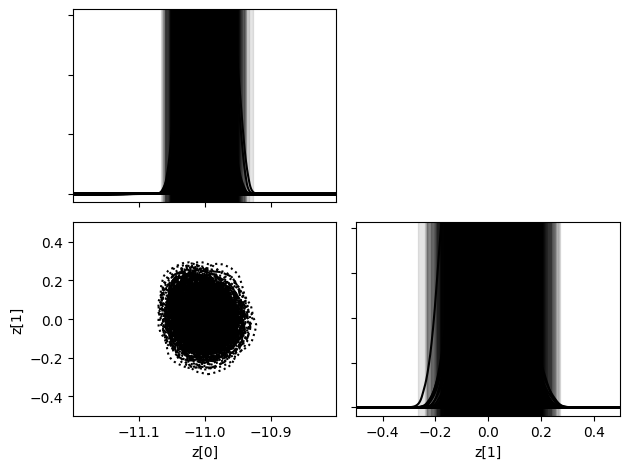

In [57]:
# Code for 2d only logratios
N = 1000
prior_samples = get_grid(N, -11.2, -10.8, -0.5, 0.5)
lrs_total = swyft.LogRatioSamples(
    logratios=torch.zeros((N * N, 1)),
    params=torch.zeros((N * N, 1, 2)),
    parnames=[
        ["z[0]", "z[1]"],
    ],
)
#swyft.plot_corner(bound_logratios, parnames=["z[0]", "z[1]"], bins=1000)
for i in range(100):
    print(f"\nAnalysing observation #{i + 1}")
    #observation = sim.sample(conditions={"z": np.array([-11.0, 0.0, np.random.normal(3., 0.6), np.random.normal(15., 3.)])})
    observation = sim.sample(conditions={"z": np.array([-11.0, 0.0, 3., 15.])})
    observation["data"] = torch.tensor(observation["coarse_grained_data"])
    dict_keys = list(observation.keys())
    for k in dict_keys:
        if k not in ["z", "data"]:
            observation.pop(k)
    lrs_out = trainer.infer(bound_nn, observation, prior_samples, batch_size=64000)
    if i != 0:
        swyft.plot_corner(lrs_out, fig=plt.gcf(), parnames=["z[0]", "z[1]"], bins=1000)
    else:
        swyft.plot_corner(lrs_out, parnames=["z[0]", "z[1]"], bins=1000)
    lrs_total.logratios += lrs_out.logratios
    lrs_total.params = lrs_out.params

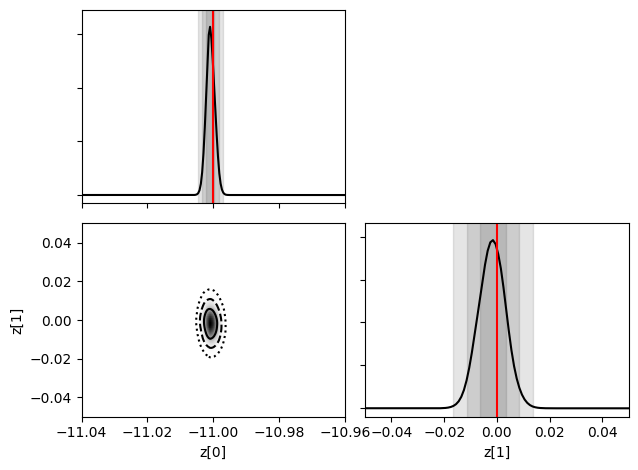

In [59]:
swyft.plot_corner(lrs_total, parnames=lrs_total.parnames[0], bins=1000, smooth=0.0)
lims = [[-11.04, -10.96], [-0.05, 0.05]]
for j in range(2):
    ax = plt.subplot(2, 2, 2 * j + j + 1)
    plt.axvline(observation["z"][j], c="r")
for i in range(2):
    for j in range(i + 1):
        ax = plt.subplot(2, 2, 2 * i + j + 1)
        if i != j:
            ax.set_xlim(lims[j])
            ax.set_ylim(lims[i])
        elif i == j:
            ax.set_xlim(lims[i])


Analysing observation #1


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.18it/s]

Analysing observation #2


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.27it/s]

Analysing observation #3


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.44it/s]

Analysing observation #4


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.27it/s]

Analysing observation #5


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.28it/s]

Analysing observation #6


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.22it/s]

Analysing observation #7


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.25it/s]

Analysing observation #8


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.26it/s]

Analysing observation #9


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.21it/s]

Analysing observation #10


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.26it/s]

Analysing observation #11


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.24it/s]

Analysing observation #12


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.57it/s]

Analysing observation #13


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.29it/s]

Analysing observation #14


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.28it/s]

Analysing observation #15


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.26it/s]

Analysing observation #16


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.32it/s]

Analysing observation #17


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.08it/s]

Analysing observation #18


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.23it/s]

Analysing observation #19


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.27it/s]

Analysing observation #20


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.25it/s]

Analysing observation #21


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.26it/s]

Analysing observation #22


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.29it/s]

Analysing observation #23


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.21it/s]

Analysing observation #24


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.17it/s]

Analysing observation #25


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.26it/s]

Analysing observation #26


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.27it/s]

Analysing observation #27


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.21it/s]

Analysing observation #28


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.28it/s]

Analysing observation #29


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.27it/s]

Analysing observation #30


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.22it/s]

Analysing observation #31


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.26it/s]

Analysing observation #32


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.29it/s]

Analysing observation #33


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.57it/s]

Analysing observation #34


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.24it/s]

Analysing observation #35


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.27it/s]

Analysing observation #36


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.22it/s]

Analysing observation #37


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.22it/s]

Analysing observation #38


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.24it/s]

Analysing observation #39


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.25it/s]

Analysing observation #40


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.19it/s]

Analysing observation #41


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.11it/s]

Analysing observation #42


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.54it/s]

Analysing observation #43


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.27it/s]

Analysing observation #44


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.20it/s]

Analysing observation #45


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.21it/s]

Analysing observation #46


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.30it/s]

Analysing observation #47


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.27it/s]

Analysing observation #48


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.21it/s]

Analysing observation #49


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.27it/s]

Analysing observation #50


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.28it/s]

Analysing observation #51


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.51it/s]

Analysing observation #52


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.53it/s]

Analysing observation #53


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.17it/s]

Analysing observation #54


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.11it/s]

Analysing observation #55


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.16it/s]

Analysing observation #56


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.21it/s]

Analysing observation #57


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.25it/s]

Analysing observation #58


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.19it/s]

Analysing observation #59


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.18it/s]

Analysing observation #60


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.20it/s]

Analysing observation #61


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.23it/s]

Analysing observation #62


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.21it/s]

Analysing observation #63


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.23it/s]

Analysing observation #64


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.24it/s]

Analysing observation #65


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.24it/s]

Analysing observation #66


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.22it/s]

Analysing observation #67


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.45it/s]

Analysing observation #68


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.47it/s]

Analysing observation #69


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.58it/s]

Analysing observation #70


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.49it/s]

Analysing observation #71


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.53it/s]

Analysing observation #72


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.47it/s]

Analysing observation #73


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.52it/s]

Analysing observation #74


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.25it/s]

Analysing observation #75


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.25it/s]

Analysing observation #76


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.22it/s]

Analysing observation #77


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.16it/s]

Analysing observation #78


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.19it/s]

Analysing observation #79


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.23it/s]

Analysing observation #80


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.23it/s]

Analysing observation #81


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.21it/s]

Analysing observation #82


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.20it/s]

Analysing observation #83


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.20it/s]

Analysing observation #84


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.14it/s]

Analysing observation #85


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.13it/s]

Analysing observation #86


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.14it/s]

Analysing observation #87


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.13it/s]

Analysing observation #88


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.25it/s]

Analysing observation #89


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.16it/s]

Analysing observation #90


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.21it/s]

Analysing observation #91


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.02it/s]

Analysing observation #92


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.20it/s]

Analysing observation #93


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.19it/s]

Analysing observation #94


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.19it/s]

Analysing observation #95


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.24it/s]

Analysing observation #96


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.18it/s]

Analysing observation #97


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.25it/s]

Analysing observation #98


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.17it/s]

Analysing observation #99


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.21it/s]

Analysing observation #100


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.23it/s]


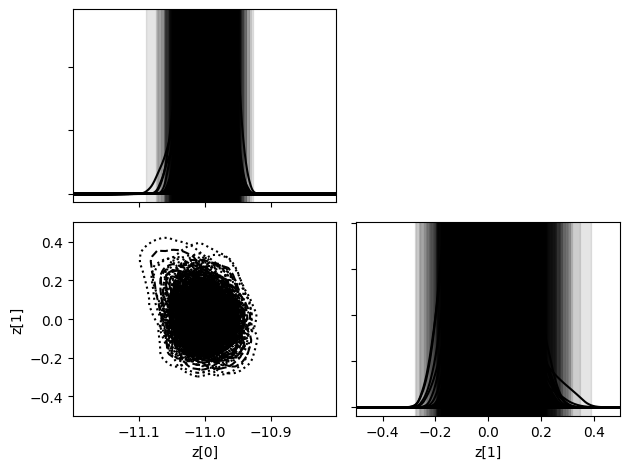

In [70]:
# Code for 2d only logratios
N = 1000
prior_samples = get_grid(N, -11.2, -10.8, -0.5, 0.5)
vary_lrs_total = swyft.LogRatioSamples(
    logratios=torch.zeros((N * N, 1)),
    params=torch.zeros((N * N, 1, 2)),
    parnames=[
        ["z[0]", "z[1]"],
    ],
)
#swyft.plot_corner(bound_logratios, parnames=["z[0]", "z[1]"], bins=1000)
for i in range(100):
    print(f"\nAnalysing observation #{i + 1}")
    observation = sim.sample(conditions={"z": np.array([-11.0, 0.0, np.random.normal(3., 0.6), np.random.normal(15., 3.)])})
    #observation = sim.sample(conditions={"z": np.array([-11.0, 0.0, 3., 15.])})
    observation["data"] = torch.tensor(observation["coarse_grained_data"])
    dict_keys = list(observation.keys())
    for k in dict_keys:
        if k not in ["z", "data"]:
            observation.pop(k)
    lrs_out = trainer.infer(bound_nn, observation, prior_samples, batch_size=64000)
    if i != 0:
        swyft.plot_corner(lrs_out, fig=plt.gcf(), parnames=["z[0]", "z[1]"], bins=1000)
    else:
        swyft.plot_corner(lrs_out, parnames=["z[0]", "z[1]"], bins=1000)
    vary_lrs_total.logratios += lrs_out.logratios
    vary_lrs_total.params = lrs_out.params

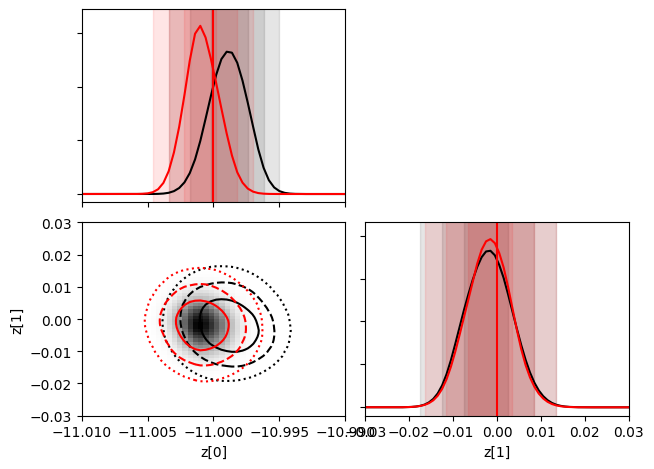

In [71]:
swyft.plot_corner(vary_lrs_total, parnames=vary_lrs_total.parnames[0], bins=1000, smooth=0.0)
swyft.plot_corner(lrs_total, parnames=vary_lrs_total.parnames[0], bins=1000, color='red', fig=plt.gcf(), smooth=0.0)
lims = [[-11.01, -10.99], [-0.03, 0.03]]
for j in range(2):
    ax = plt.subplot(2, 2, 2 * j + j + 1)
    plt.axvline(observation["z"][j], c="r")
for i in range(2):
    for j in range(i + 1):
        ax = plt.subplot(2, 2, 2 * i + j + 1)
        if i != j:
            ax.set_xlim(lims[j])
            ax.set_ylim(lims[i])
        elif i == j:
            ax.set_xlim(lims[i])

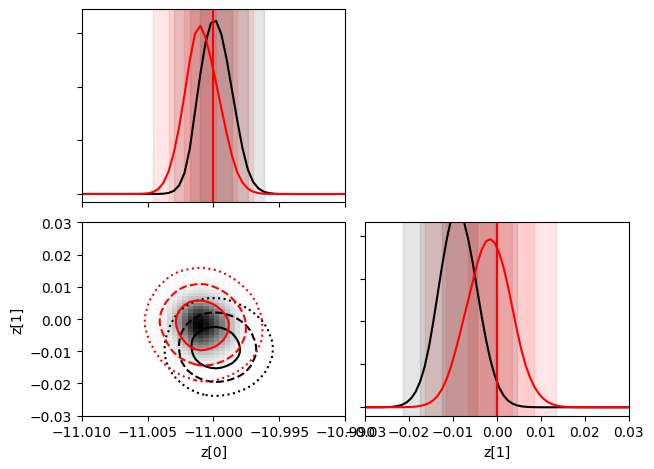

In [69]:
swyft.plot_corner(vary_lrs_total, parnames=vary_lrs_total.parnames[0], bins=1000, smooth=0.0)
swyft.plot_corner(lrs_total, parnames=vary_lrs_total.parnames[0], bins=1000, color='red', fig=plt.gcf(), smooth=0.0)
lims = [[-11.01, -10.99], [-0.03, 0.03]]
for j in range(2):
    ax = plt.subplot(2, 2, 2 * j + j + 1)
    plt.axvline(observation["z"][j], c="r")
for i in range(2):
    for j in range(i + 1):
        ax = plt.subplot(2, 2, 2 * i + j + 1)
        if i != j:
            ax.set_xlim(lims[j])
            ax.set_ylim(lims[i])
        elif i == j:
            ax.set_xlim(lims[i])

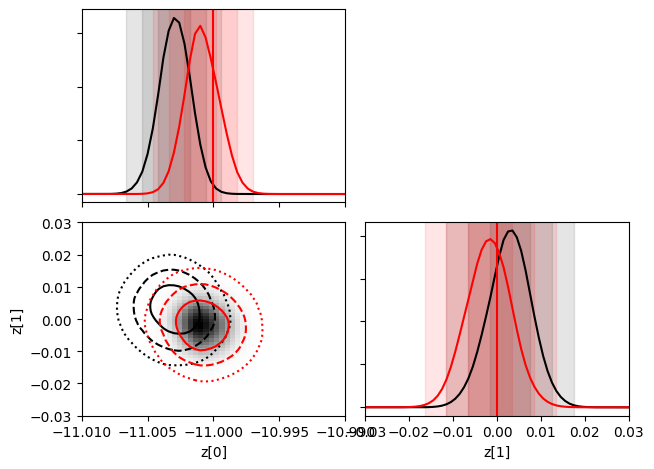

In [67]:
swyft.plot_corner(vary_lrs_total, parnames=vary_lrs_total.parnames[0], bins=1000, smooth=0.0)
swyft.plot_corner(lrs_total, parnames=vary_lrs_total.parnames[0], bins=1000, color='red', fig=plt.gcf(), smooth=0.0)
lims = [[-11.01, -10.99], [-0.03, 0.03]]
for j in range(2):
    ax = plt.subplot(2, 2, 2 * j + j + 1)
    plt.axvline(observation["z"][j], c="r")
for i in range(2):
    for j in range(i + 1):
        ax = plt.subplot(2, 2, 2 * i + j + 1)
        if i != j:
            ax.set_xlim(lims[j])
            ax.set_ylim(lims[i])
        elif i == j:
            ax.set_xlim(lims[i])

In [75]:
import importlib as imp
imp.reload(swyft)

<module 'swyft' from '/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/swyft/__init__.py'>

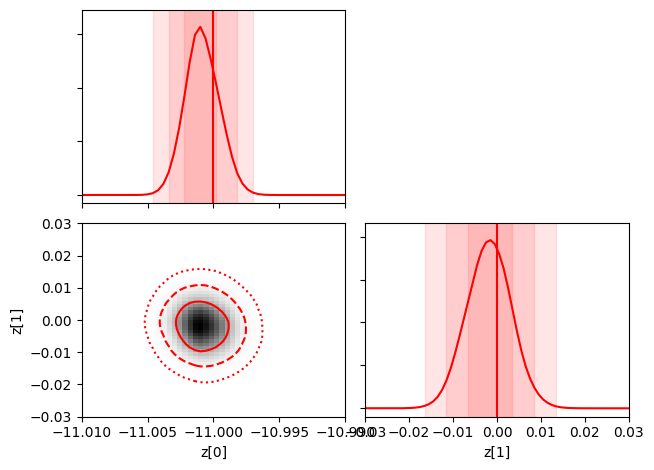

In [76]:
swyft.plot_corner(lrs_total, parnames=vary_lrs_total.parnames[0], bins=1000, color='red', smooth=0.0)
lims = [[-11.01, -10.99], [-0.03, 0.03]]
for j in range(2):
    ax = plt.subplot(2, 2, 2 * j + j + 1)
    plt.axvline(observation["z"][j], c="r")
for i in range(2):
    for j in range(i + 1):
        ax = plt.subplot(2, 2, 2 * i + j + 1)
        if i != j:
            ax.set_xlim(lims[j])
            ax.set_ylim(lims[i])
        elif i == j:
            ax.set_xlim(lims[i])

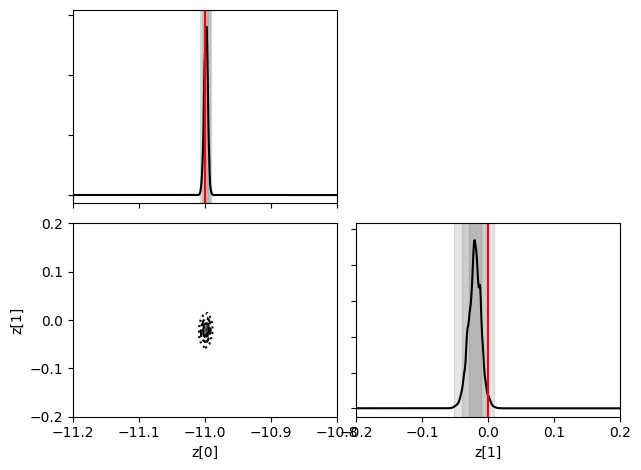

In [60]:
swyft.plot_corner(lrs_total, parnames=lrs_total.parnames[0], bins=1000, smooth=1.3)
lims = [[-11.2, -10.8], [-0.2, 0.2]]
for j in range(2):
    ax = plt.subplot(2, 2, 2 * j + j + 1)
    plt.axvline(observation["z"][j], c="r")
for i in range(2):
    for j in range(i + 1):
        ax = plt.subplot(2, 2, 2 * i + j + 1)
        if i != j:
            ax.set_xlim(lims[j])
            ax.set_ylim(lims[i])
        elif i == j:
            ax.set_xlim(lims[i])

In [72]:
import copy
prior_sim = copy.deepcopy(sim)

In [76]:
sim.bounds

array([[-11.65577126, -10.79502106],
       [ -0.90164167,   1.14619088],
       [  0.        ,   6.        ],
       [  0.        ,  30.        ]])

In [87]:
prior_sim.prior.bounds = np.array([[-11.15, -10.85],
       [ -0.3,   0.3],
       [  0.        ,   6.        ],
       [  0.        ,  30.        ]])

In [78]:
samps = prior_sim.sample(targets=['z'], N=1000)

100%|██████████| 1000/1000 [00:00<00:00, 35617.39it/s]


100%|██████████| 1000000/1000000 [00:02<00:00, 333863.78it/s]



Analysing observation #1


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

Predicting DataLoader 0: 100%|██████████| 63/63 [00:06<00:00, 10.14it/s]


AssertionError: The upper bound must be strictly larger than the lower bound

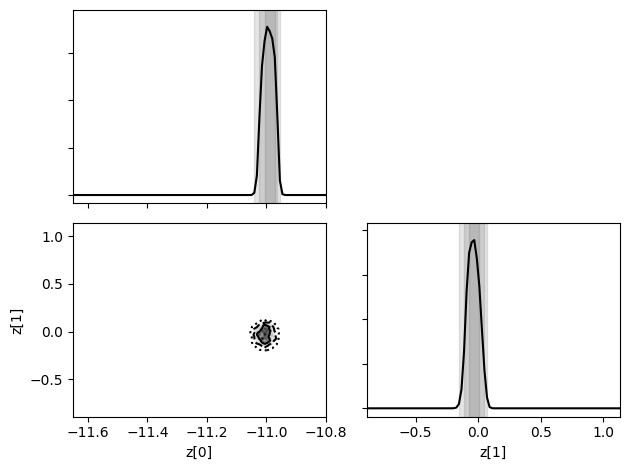

In [40]:
prior_samples = prior_sim.sample(targets=["z"], N=1_000_000)
lrs_total = swyft.LogRatioSamples(
    logratios=torch.zeros((1_000_000, 1)),
    params=torch.zeros((1_000_000, 1, 2)),
    parnames=[
        ["z[0]", "z[1]"],
    ],
)
swyft.plot_corner(logratios, parnames=["z[0]", "z[1]"])
for i in range(20):
    print(f"\nAnalysing observation #{i + 1}")
    #observation = sim.sample(conditions={"z": np.array([-11.0, 0.0, np.random.normal(3., 0.6), np.random.normal(15., 3.)])})
    observation = sim.sample(conditions={"z": np.array([-11.0, 0.0, 3., 15.])})
    observation["data"] = torch.tensor(observation["coarse_grained_data"])
    dict_keys = list(observation.keys())
    for k in dict_keys:
        if k not in ["z", "data"]:
            observation.pop(k)
    lrs_out = trainer.infer(network, observation, prior_samples, batch_size=16000)
    swyft.plot_corner(lrs_out, fig=plt.gcf(), parnames=["z[0]", "z[1]"])
    lrs_total.logratios += lrs_out[1].logratios
    lrs_total.params = lrs_out[1].params

In [58]:
import copy
new_lrs = copy.deepcopy(lrs_total)
new_lrs.logratios = lrs_total.logratios + torch.max(lrs_total.logratios)

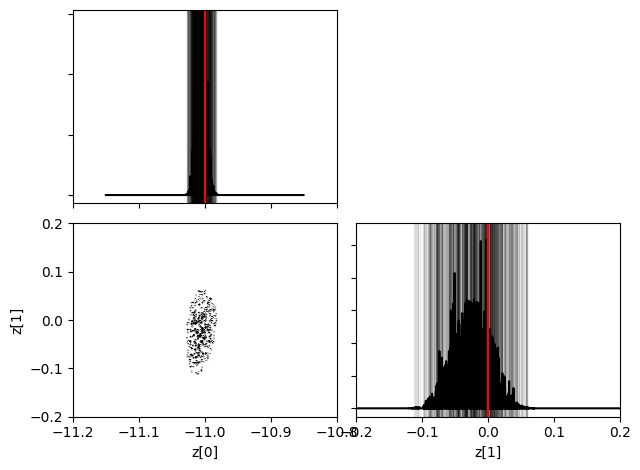

In [96]:
swyft.plot_corner(lrs_total, parnames=[f"z[{idx}]" for idx in range(2)], smooth=0.0, bins=10000);
lims = [[-11.2, -10.8], [-0.2, 0.2]]
for j in range(2):
    ax = plt.subplot(2, 2, 2 * j + j + 1)
    plt.axvline(observation["z"][j], c="r")
for i in range(2):
    for j in range(i + 1):
        ax = plt.subplot(2, 2, 2 * i + j + 1)
        if i != j:
            ax.set_xlim(lims[j])
            ax.set_ylim(lims[i])
        elif i == j:
            ax.set_xlim(lims[i])

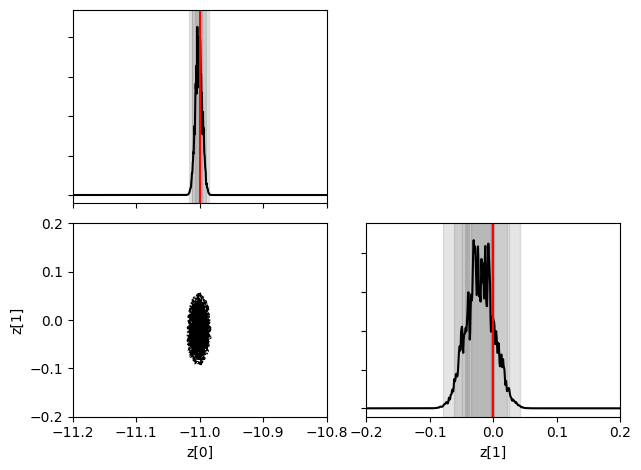

In [45]:
swyft.plot_corner(lrs_total, parnames=[f"z[{idx}]" for idx in range(2)], smooth=1.0, bins=3000);
lims = [[-11.2, -10.8], [-0.2, 0.2]]
for j in range(2):
    ax = plt.subplot(2, 2, 2 * j + j + 1)
    plt.axvline(observation["z"][j], c="r")
for i in range(2):
    for j in range(i + 1):
        ax = plt.subplot(2, 2, 2 * i + j + 1)
        if i != j:
            ax.set_xlim(lims[j])
            ax.set_ylim(lims[i])
        elif i == j:
            ax.set_xlim(lims[i])

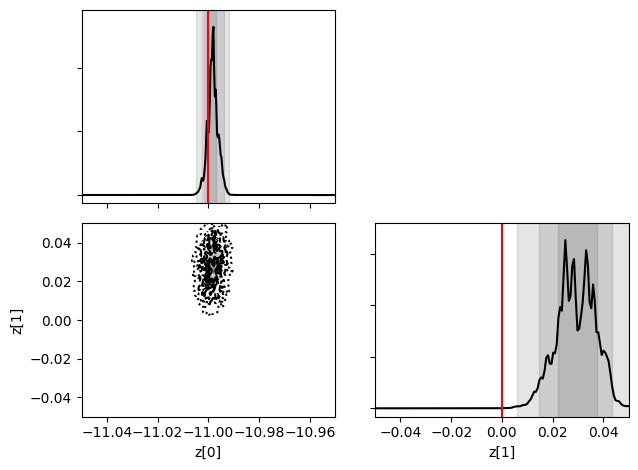

In [64]:
swyft.plot_corner(lrs_total, parnames=[f"z[{idx}]" for idx in range(2)], smooth=1.0, bins=3000);
lims = [[-11.05, -10.95], [-0.05, 0.05]]
for j in range(2):
    ax = plt.subplot(2, 2, 2 * j + j + 1)
    plt.axvline(observation["z"][j], c="r")
for i in range(2):
    for j in range(i + 1):
        ax = plt.subplot(2, 2, 2 * i + j + 1)
        if i != j:
            ax.set_xlim(lims[j])
            ax.set_ylim(lims[i])
        elif i == j:
            ax.set_xlim(lims[i])

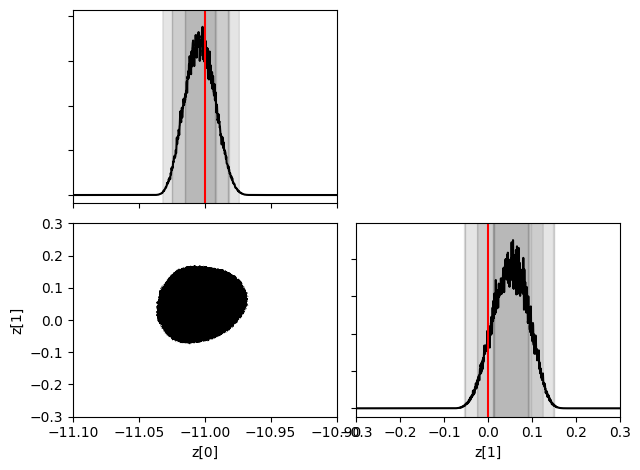

In [90]:
swyft.plot_corner(lrs_total, parnames=[f"z[{idx}]" for idx in range(2)], smooth=1.0, bins=3000);
lims = [[-11.1, -10.9], [-0.3, 0.3]]
for j in range(2):
    ax = plt.subplot(2, 2, 2 * j + j + 1)
    plt.axvline(observation["z"][j], c="r")
for i in range(2):
    for j in range(i + 1):
        ax = plt.subplot(2, 2, 2 * i + j + 1)
        if i != j:
            ax.set_xlim(lims[j])
            ax.set_ylim(lims[i])
        elif i == j:
            ax.set_xlim(lims[i])

In [1]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    They weights are in effect first normalized so that they 
    sum to 1 (and so they must not all be 0).

    values, weights -- NumPy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, np.sqrt(variance))

def compute_stats(logratios):
    values_1 = logratios.params[:, 0, 0].numpy()
    values_2 = logratios.params[:, 0, 1].numpy()
    weights = np.exp(logratios.logratios[:, 0].numpy() - np.max(logratios.logratios[:, 0].numpy()))
    print("\t\t mean\t\t std")
    means = []
    stds = []
    mean, std1 = weighted_avg_and_std(values_1, weights)
    print(f"Parameter {j}:\t", mean, "\t", std1)
    mean, std = weighted_avg_and_std(values_2, weights)
    print(f"Parameter {j}:\t", mean, "\t", std)
    means.append(mean)
    stds.append(std)
    return means, stds